In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

1 78.94948878749086 0.5741932709897839 0.0
2 32.896060094153 0.47921216736454936 0.0
3 17.21852711352666 0.40769667628567907 0.0
4 11.886198200407648 0.35271700292430774 0.0
5 9.496796983598701 0.30976044802158625 0.0
6 7.9689811842937095 0.2756712477625452 0.0
7 6.823895148183375 0.2482011026126175 0.0
8 5.924751745330558 0.22573098199875194 0.0
9 5.205892317534688 0.2070854239343637 0.0
10 4.623436719587232 0.19140376545338528 0.0
11 4.145335880073609 0.1780498494087583 0.0
12 3.7479026893463505 0.16654847350104915 0.0
13 3.413541452890638 0.15654058626928583 0.0
14 3.129126053066198 0.14775163477237535 0.0
15 2.8847648899080993 0.13996911378036886 0.0
16 2.672917364575527 0.13302655263979035 0.0
17 2.487763658872413 0.12679201007646512 0.0
18 2.324756245645876 0.12115973645100293 0.0
19 2.1803046042181395 0.11604407389361554 0.0
20 2.0515197039843085 0.11137494543828778 0.0
21 1.9360881833343417 0.10709449044678729 0.0
22 1.832118990076405 0.10315452098060517 0.0
23 1.73803750374974

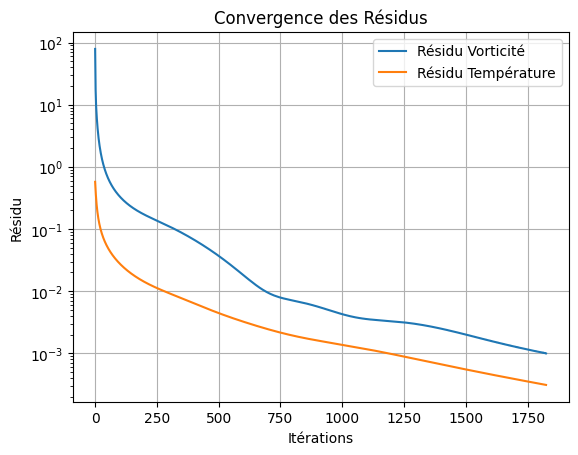

In [24]:
# --- PARAMÈTRES PHYSIQUES ET NUMÉRIQUES ---
nx, ny = 40, 40
Lx, Ly = 1.0, 1.0
dx, dy = Lx/nx, Ly/ny
Re = 100.0
Pr = 0.71
Ri = 1.0
U0 = 1.0  # Vitesse paroi supérieure

dt = 0.01
alpha_sor = 1.725
tol_sor = 1e-6
tol_steady_state = 1e-3

# --- INITIALISATION ---
T = np.zeros((nx, ny))
w = np.zeros((nx, ny))
psi = np.zeros((nx, ny))
T[0, :] = 1.0  # Paroi gauche chaude


assert U0*dt/dy < 1, "Condition de stabilité CFL violée!"



# ----------------------------------------------------------------             
# ÉTAPE 0 : OUTILS (Thomas & Vitesses)
# ----------------------------------------------------------------

def solve_thomas(a, b, c, d):
    """Résout un système tridiagonal."""
    n = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for i in range(1, n):
        m = ac[i-1]/bc[i-1]
        bc[i] -= m*cc[i-1]
        dc[i] -= m*dc[i-1]
    x = np.zeros(n)
    x[-1] = dc[-1]/bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i]-cc[i]*x[i+1])/bc[i]
    return x

def get_velocity(psi):
    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    u[:, 1:-1] = (psi[:, 2:] - psi[:, :-2]) / (2*dy)
    v[1:-1, :] = -(psi[2:, :] - psi[:-2, :]) / (2*dx)
    return u, v

# ----------------------------------------------------------------
# ÉTAPE 1 : RÉSOLUTION ÉNERGIE (ADI)
# ----------------------------------------------------------------

def solve_energy_adi(T, psi, dt, dx, dy, Re, Pr):
    u, v = get_velocity(psi)
    T_new = T.copy()
    diff_coeff = 1.0 / (Re * Pr)
    
    # Demi-pas 1 : Implicite en X, Explicite en Y
    for j in range(1, ny-1):
        a = np.full(nx-3, -dt/(2*dx**2) * diff_coeff)
        c = np.full(nx-3, -dt/(2*dx**2) * diff_coeff)
        b = np.full(nx-2, 1 + dt/(dx**2) * diff_coeff)
        
        # Termes explicites (Y) + Advection
        d = np.zeros(nx-2)
        for i in range(1, nx-1):
            adv = u[i,j]*(T[i+1,j]-T[i-1,j])/(2*dx) + v[i,j]*(T[i,j+1]-T[i,j-1])/(2*dy)
            diff_y = diff_coeff * (T[i,j+1] - 2*T[i,j] + T[i,j-1]) / dy**2
            d[i-1] = T[i,j] + dt/2 * (diff_y - adv)
        
        # Conditions aux limites (Dirichlet)
        d[0] -= a[0] * T[0,j]
        d[-1] -= c[-1] * T[-1,j]
        T_new[1:-1, j] = solve_thomas(a, b, c, d)
        
    # Demi-pas 2 : Implicite en Y, Explicite en X
    # (Logique similaire inversée à implémenter ici)
    return T_new

# ----------------------------------------------------------------
# ÉTAPE 2 : CALCUL DE W SUR LES FRONTIÈRES (Thom)
# ----------------------------------------------------------------

def update_vorticity_boundary(w, psi, dx, dy, U0):
    # Paroi Bas (y=0, psi=0)
    w[:, 0] = -2 * psi[:, 1] / dy**2
    # Paroi Haut (y=Ly, psi=0, u=U0)
    w[:, -1] = -2 * (psi[:, -2] + U0 * dy) / dy**2
    # Paroi Gauche (x=0, psi=0)
    w[0, :] = -2 * psi[1, :] / dx**2
    # Paroi Droite (x=Lx, psi=0)
    w[-1, :] = -2 * psi[-2, :] / dx**2
    return w

# ----------------------------------------------------------------
# ÉTAPE 3 : RÉSOLUTION W À L'INTÉRIEUR
# ----------------------------------------------------------------

def solve_vorticity_interior(w, T, psi, dt, dx, dy, Re, Ri):
    u, v = get_velocity(psi)
    w_new = w.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            adv = u[i,j]*(w[i+1,j]-w[i-1,j])/(2*dx) + v[i,j]*(w[i,j+1]-w[i,j-1])/(2*dy)
            diff = (1/Re) * ((w[i+1,j]-2*w[i,j]+w[i-1,j])/dx**2 + (w[i,j+1]-2*w[i,j]+w[i,j-1])/dy**2)
            buoyancy = Ri * (T[i+1,j] - T[i-1,j]) / (2*dx)
            w_new[i,j] = w[i,j] + dt * (-adv + diff + buoyancy)
    return w_new

# ----------------------------------------------------------------
# ÉTAPE 4 : RÉSOLUTION POISSON PSI (SOR)
# ----------------------------------------------------------------

def solve_poisson_psi(psi, w, dx, alpha_sor, tol):
    for _ in range(500): # Limite itérations
        psi_old = psi.copy()
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                target = 0.25 * (psi[i+1,j] + psi[i-1,j] + psi[i,j+1] + psi[i,j-1] + dx**2 * w[i,j])
                psi[i,j] = (1 - alpha_sor) * psi[i,j] + alpha_sor * target
        if np.linalg.norm(psi - psi_old) < tol:
            break
    return psi

# ----------------------------------------------------------------
# BOUCLE PRINCIPALE
# ----------------------------------------------------------------

img_dic = {'T': [T], 'w': [w], 'psi': [psi]}
u, v = get_velocity(psi)
img_dic['u'] = [u]
img_dic['v'] = [v]


nmax = 2000
n = 0

res_w = []
res_psi = []
res_T = []

while n <= nmax:

    T_new = solve_energy_adi(T, psi, dt, dx, dy, Re, Pr)
    w_new = update_vorticity_boundary(w, psi, dx, dy, U0)
    w_new = solve_vorticity_interior(w_new, T_new, psi, dt, dx, dy, Re, Ri)
    psi_new = solve_poisson_psi(psi, w_new, dx, alpha_sor, tol_sor)

    res_w.append(np.linalg.norm(w_new - w))
    res_psi.append(np.linalg.norm(psi_new - psi))
    res_T.append(np.linalg.norm(T_new - T))

    if res_w[-1] < tol_steady_state and res_T[-1] < tol_steady_state:
            print(f"\nConvergence atteinte à l'itération {n} !")
            break

    T, w, psi = T_new, w_new, psi_new

    if n % 10 == 0:
        img_dic['T'].append(T.copy())
        img_dic['w'].append(w.copy())
        img_dic['psi'].append(psi.copy())
        u_save, v_save = get_velocity(psi)
        img_dic['u'].append(u_save.copy())
        img_dic['v'].append(v_save.copy())
    
    n += 1
    print(n, res_w[-1], res_T[-1], res_psi[-1])

plt.plot(res_w, label='Résidu Vorticité')
plt.plot(res_T, label='Résidu Température')
plt.yscale('log')
plt.xlabel('Itérations')
plt.ylabel('Résidu')
plt.legend()
plt.title('Convergence des Résidus')
plt.grid()
plt.show()

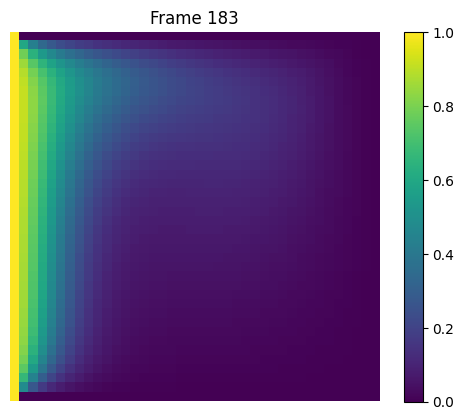

In [25]:
def animer_matrices(liste_matrices, fps=20, save_path=None):
    fig, ax = plt.subplots()
    
    # Initialisation de l'affichage avec la première matrice
    # cmap='viridis' est souvent mieux pour les données scientifiques que 'gray'
    im = ax.imshow(np.rot90(liste_matrices[0]), animated=True, cmap='viridis')
    plt.colorbar(im) # Optionnel : affiche l'échelle des valeurs
    ax.axis('off')

    # Fonction de mise à jour appelée pour chaque frame
    def update(i):
        im.set_array(np.rot90(liste_matrices[i]))
        ax.set_title(f"Frame {i}")
        return [im]

    # Création de l'animation
    # interval = délai entre images en millisecondes (1000 / fps)
    ani = animation.FuncAnimation(fig, update, frames=len(liste_matrices), 
                        interval=1000/fps, blit=True)

    # SAUVEGARDE (Optionnel)
    if save_path:
        if save_path.endswith('.gif'):
            ani.save(save_path, writer='pillow', fps=fps)
        else:
            # Nécessite l'installation de 'ffmpeg' sur votre ordinateur
            ani.save(save_path, writer='ffmpeg', fps=fps)
    
    plt.show()
    return ani

animer_matrices(img_dic['T'], fps=24, save_path='mon_animation.gif')
# Exemple d'utilisation :
# animer_matrices(mes_matrices, fps=24, save_path='mon_animation.gif')